In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nilearn.plotting import plot_stat_map 
import seaborn as sns
import pickle
import matplotlib.cm as cm

In [2]:
import clustering_functions
from clustering_functions import KMeansCorrelation

In [3]:
# Inspecting the maps and silhouette plots for each number of clusters, I chose 3 as the optimal
kmeans_object = pickle.load(open("./CAP_ncluster_selection/kmeans_cluster_object_3cluster", "rb"))

# Project my dataset onto the centroids

Essentially, I can compute the distance between each of my timepoints and the previously computed centroids.

In [4]:
#locate my data
final_data_folder='/data/chamal/projects/mila/2021_fMRI_dev/part2_phgy_fmri_project/4_derivatives/rabies_runs/local_data_final_runs'
epi_files_local = sorted(glob.glob(final_data_folder + '/rabies_out_cc-v050_05smoothed_lowpass/confound_correction_datasink/cleaned_timeseries/*/*rest*'))
commonspace_template_file_local = os.path.abspath(final_data_folder + '/rabies_out_preprocess-v050/bold_datasink/commonspace_resampled_template/resampled_template.nii.gz')
commonspace_mask_file_local = os.path.abspath(final_data_folder + '/rabies_out_preprocess-v050/bold_datasink/commonspace_mask/_scan_info_subject_idPHG001.session1_split_name_sub-PHG001_ses-1_acq-RARE_T2w/_run_1/sub-PHG001_ses-1_task-rest_acq-EPI_run-1_bold_RAS_EPI_brain_mask.nii.gz')

In [5]:
# load all the epis from my dataset into a dictionary
epi_local_flat, epi_local_shape_dict  = clustering_functions.extract_array_of_epis_with_dict(epi_files_local, 
                                                                           commonspace_mask_file_local, 
                                                                           [0,len(epi_files_local)], None, False, False)

 loading file 46 out of 46

In [6]:
#load the boolean series for censoring according to the phgy (so that fmri and phgy dimensions match)
# this was the output from the phgy_censor_and_combine.ipynb script
phgy_censoring = pickle.load(open("../../../4_derivatives/final_phgy_censored/pickle_files/bool_series_phgy-nan_censoring_withEdgeCutoff", "rb"))
phgy_censoring = phgy_censoring.to_frame(name = "False = Masked Frames").reset_index()

5


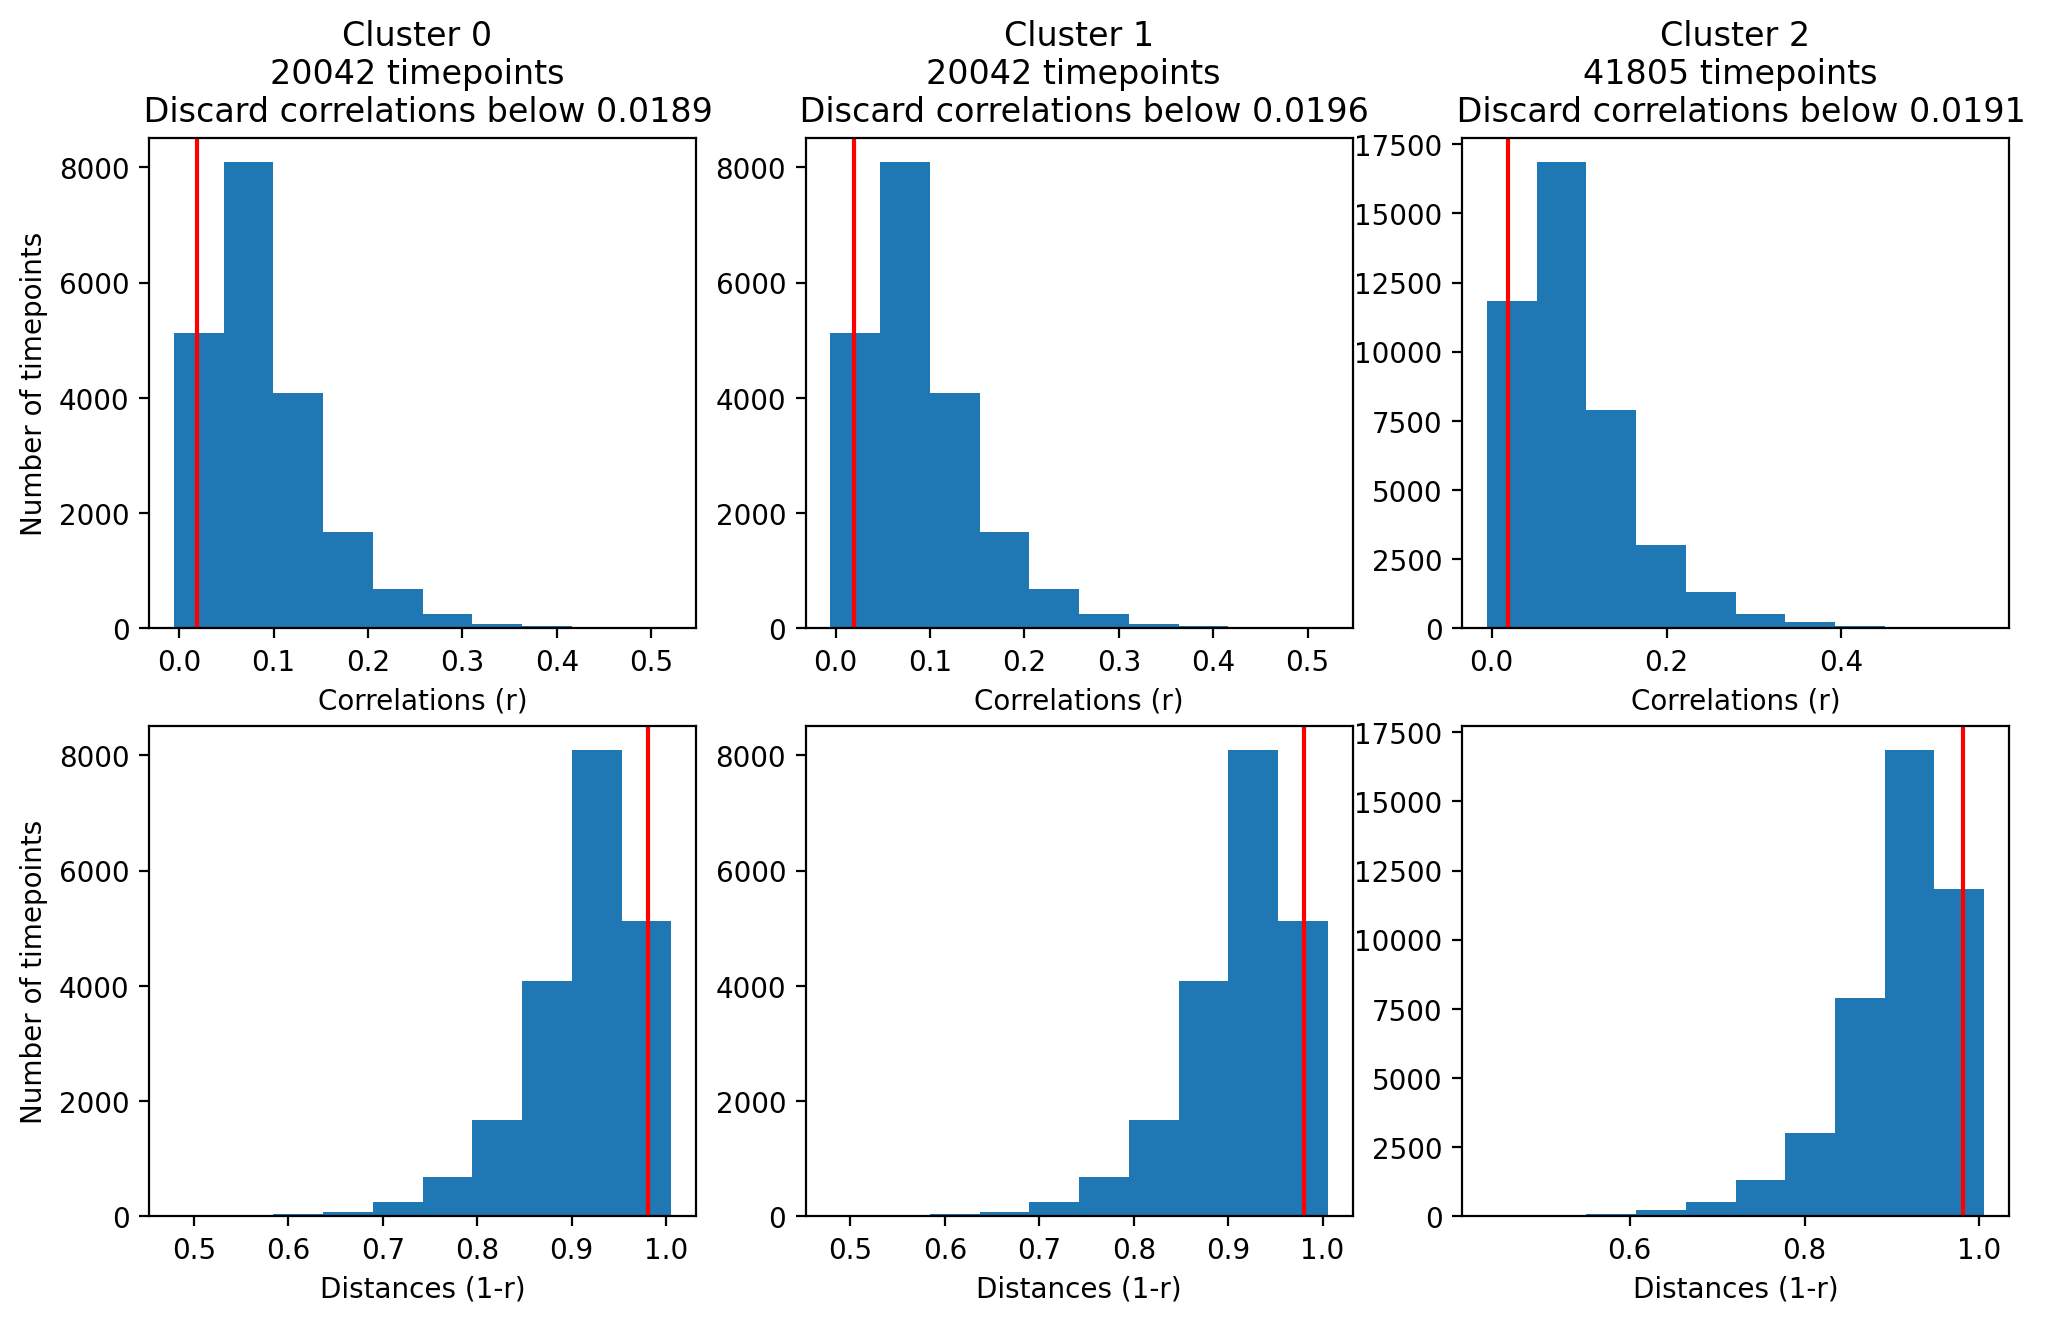

In [7]:
#predict the correlation between my timepoints and the centroids
correlations_within_clust, prediction = kmeans_object.predict(np.transpose(epi_local_flat))
correlations = kmeans_object.transform(np.transpose(epi_local_flat))

In [8]:
#apply the boolean censoring so the timepoints that are excluded from physiology are also excluded from the final timeseries of correlations with the centroid
predictions_phgycensored = pd.DataFrame(prediction).loc[phgy_censoring['False = Masked Frames'], :].reset_index(drop = True)
correlations_phgycensored = pd.DataFrame(correlations).loc[phgy_censoring['False = Masked Frames'], :].reset_index(drop = True)
correlations_within_clust_phgycensored = pd.DataFrame(correlations_within_clust).loc[phgy_censoring['False = Masked Frames'], :].reset_index(drop = True)

In [9]:
#save outputs for easy access next time
pickle.dump(correlations_phgycensored.to_numpy(), open("./kmeans_objects_pickle/correlations_mediso-to-local_phgycensored_05smoothed_lowpass",
                                                    "wb"))
pickle.dump(correlations, open("./kmeans_objects_pickle/correlations_mediso-to-local_05smoothed_lowpass",
                                                    "wb"))

# Visualize the clusters on my data

This section and the next are simply for sanity checks that everything looks good when we project my dataset into the centroid space

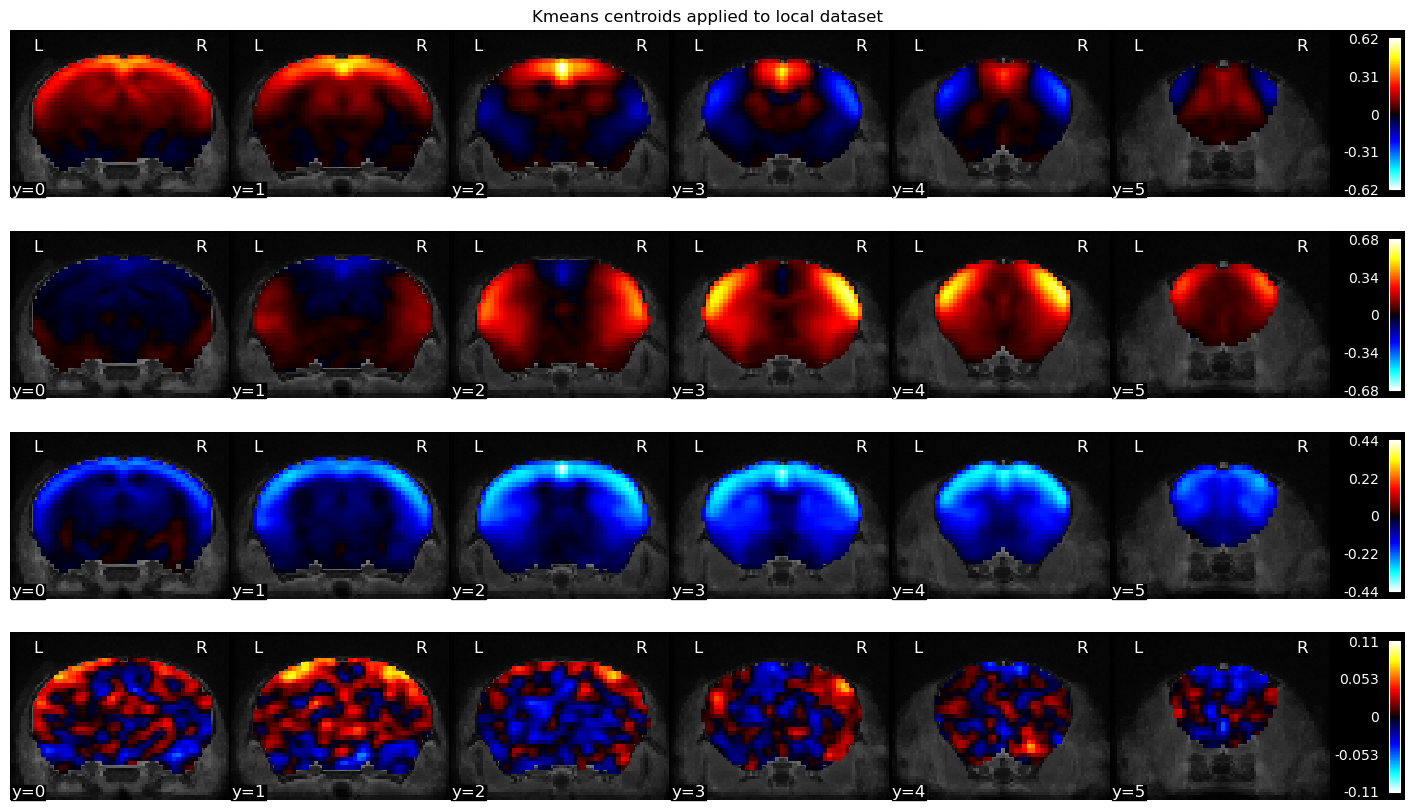

In [10]:
n_clusters = 4
fig2,axs = plt.subplots(nrows=4, ncols=1, figsize=(18,10))
#loop over all clusters and plot
for i in range(0, n_clusters):
    epi_censored = pd.DataFrame(epi_local_flat)
    epi_at_predict = epi_censored.loc[:, prediction==i]
    epi_toplot = np.mean(epi_at_predict.to_numpy(), axis = 1)
    plot_stat_map(clustering_functions.recover_3D(commonspace_mask_file_local,
                                                  epi_toplot),
                  bg_img=commonspace_template_file_local, axes = axs[i], cut_coords=(0,1,2,3,4,5),
                  display_mode='y', colorbar=True)
axs[0].set_title('Kmeans centroids applied to local dataset')
fig2.savefig('./kmeans_centroids_in_local' + str(n_clusters) + '.png')

# Check distribution of values across all clusters

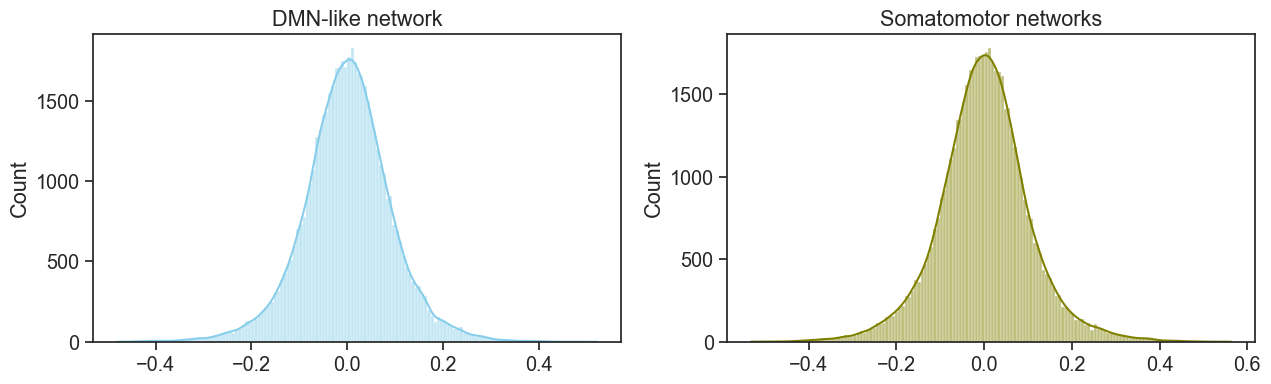

In [11]:
sns.set(style="ticks", font_scale = 1.3)

fig, axs = plt.subplots(1, 2, figsize=(15, 4))

sns.histplot(data=correlations_phgycensored.to_numpy()[:,0],  kde=True, color="skyblue", ax=axs[0], bins = 150)
sns.histplot(data=correlations_phgycensored.to_numpy()[:,1], kde=True, color="olive", ax=axs[1], bins = 150)

axs[0].set_title('DMN-like network')
axs[1].set_title('Somatomotor networks')
plt.show()

## Save CAP metrics into single csv

In [12]:
#save the values of correlation (distance) in a csv
all_cap_metrics = pd.DataFrame(correlations_phgycensored, columns = ['Corr-DMN', 'Corr-Somatomotor', 'Corr-Global'])

#add a column that corresponds to the average correlation to either somatomotor or DMN
spatialCorr_avg= (np.abs(all_cap_metrics['Corr-Somatomotor']) + np.abs(all_cap_metrics['Corr-DMN']))/2
indices_higher_dmn = np.where(all_cap_metrics['Corr-DMN'] <= all_cap_metrics['Corr-DMN'])
spatialCorr_avg[indices_higher_dmn[0]] = (-1)*spatialCorr_avg[indices_higher_dmn[0]]
all_cap_metrics['Corr-networkAvg'] = spatialCorr_avg
all_cap_metrics.to_csv('./CAP_metrics_KMeansCorr.csv')